The GSS Dataset

The General Social Survey (GSS) collects social data from the population of the United States, and it has been conducted every two years on average since 1972. The entire dataset currently consists of 29 years of GSS data. It is the only full-probability, personal-interview survey designed to monitor changes in both social characteristics and attitudes currently being conducted in the United States. Because it has been conducted for so many years, with many questions remaining the same, it is a very useful dataset to investigate trends with. 
 
Among the topics covered are civil liberties, crime and violence, intergroup tolerance, morality, national spending priorities, psychological well-being, social mobility, and stress and traumatic events. Altogether the GSS is very extensive source for sociological and attitudinal trend data covering the United States.


In [1]:
# import section

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

Preprocessing

Importing the full GSS datafile over all years does not work, so we needed to import every year separately. The files of all available years are in one directory on our computers, and LoadData function below loops through every year in the directory and appends it to the total data file. Initially we worked in Spyder as we could collaborate using Github, but there we had to load the data everytime we ran the full program, which took a lot of time. We made a separate data loading program before we realized that Jupyter works with blocks. Luckily we could incorporate some of our previous code, and we now work on this notebook through Github, although the updated file has to be uploaded to the server each time. 

In [3]:
# Data loading function

def LoadData():
    year = 1972
    total_data = {}
    years = []
    for i in range(28):
        if year == 1979 or year == 1981 or year == 1984 or year == 1986 or year ==1992:
            year += 1
        years.append(str(year))
        print year,
        data = pd.io.stata.read_stata("/Users/jorrenbosga/Desktop/AUC/Masterclass/MasterclassBDProject/GSS" + str(year) + ".DTA")
        total_data[str(year)] = data
        year += 1
        if year > 1994:
            year += 1
        
    print "Data Loaded"
    return total_data

total_data = LoadData()

 1972 1973 1974 1975 1976 1977 1978 1980 1982 1983 1985 1987 1988 1989 1990 1991 1993 1994 1996 1998 2000 2002 2004 2006 2008 2010 2012 2014 Data Loaded


Preprocessing (continued)

After having loaded the data, we noticed that the answers to the survey questions are not constant over the years. In for instance the category religion, some additional religions are added over the years. In order for us to be able to analyse the data properly, we decided that it was necessary to add all possible answers to each category for every year. The AllAnswers function does this for a specified category. If a question is left open, the entry will be NaN (not a natural number). We decided to remove these from the population, as these entries do not contribute to the data, and cause issues when left in (especially if answers are numbers).

In [27]:
# Returns a list of all possible answers in one category over all years
def AllAnswers(category):
    answers_cat = []
    for year in total_data.keys():
        if category not in total_data[year].keys():
            continue
        else:
            cat = getattr(total_data[year], category)
            for answer in cat:
                if type(answer) == str:
                    answer = answer.lower()
                if answer not in answers_cat:
                    answers_cat.append(answer)
    NaNless = []
    for item in answers_cat:
        if type(item) == str:
            NaNless.append(item)
        else:
            if np.isnan(item) == False:
                NaNless.append(item)
    return NaNless



['no', 'yes', 'refused']


The block below is dedicated to calculating proportions of answers within a certain category in one year. This is useful for getting a general idea of distributions within a single year. The first function, Count, counts the frequencies of the answers to a survey question (category), and returns them in a dictionary. The second function, CategoryCompletion, appends the answers that were not chosen or included in the options for a survey question of a single year to the output of the Counted function with a very small value (such that entropy calculations are not affected). The last function, Proportions, transforms the frequencies into proportions and returns them in a list.

In [5]:
# Counting function
# Returns dictionary with frequency of all answers in a chosen category
def Count(year, category):
    if category not in total_data[year].keys():
        return "Error: category nonexistent"
    else:
        filtered = getattr(total_data[year], category)
        counted = {}
        for answer in filtered:
            if type(answer) == str:
                answer = answer.lower()
            if answer not in counted:
                counted[answer] = 1
            else:
                counted[answer] = counted[answer] + 1   
        return counted

# Returns completed dictionary of answers to some categories with keys answers and values counts. Non-existent answers
# in some year are given count = 1e-16
def CategoryCompletion(year, category):
    frequency = Count(year, category)
    if type(frequency) == str:
        return frequency
    allanswers = AllAnswers(category)
    for answer in allanswers:
        if answer not in frequency.keys():
            frequency[answer] = 1e-16
    return frequency
    
# Proportion function
# Returns list with proportions based on counting function
def Proportions(year, category):  # input should be output of Count function
    frequencies = CategoryCompletion(year, category)
    if type(frequencies) == str:
        return frequencies
    numbervals = frequencies.values()
    population = 0
    proportions = []
    for frequency in numbervals:
        population += frequency
    for frequency in numbervals:
        proportions.append(float(frequency) / float(population))
        
    return proportions

Exploratory Analysis

While the block above focuses on single categories, it is statistically speaking more useful to look at correlations between proportions within categories. The block below performs this action by calculating the Kullback-Leibler divergence between the general opinion on a certain subject and the opinion of a subgroup on a certain subject (for example, what is the divergence between the opinion on premarital sex of protestants and the opinion of the whole population on that topic?). The block is largely similar to the block above, but the functions CrossCount, CrossCategoryComplete, and CrossProportions only take the answers of a subset of the population to a certain question into account (in code: total_data["1990", premarsx][religion == "protestant"]).

In [6]:
# Returns a dictionary of all answers to 'category1' in 'year' within subcategory of category2     
def CrossCount(year, category1, category2, subcategory):
    if category1 not in total_data[year].keys():
        return "Error: category 1 nonexistent"
    elif category2 not in total_data[year].keys():
        return "Error: category 2 & subcategory nonexistent"
    else:
        filtered = getattr(total_data[year], category1)[(getattr(total_data[year], category2)) == subcategory]
        counted = {}
        for answer in filtered:
            if type(answer) == str:
                answer = answer.lower()
            if answer not in counted:
                counted[answer] = 1
            else:
                counted[answer] += 1   
        return counted
# returns completed dictionary from crosscount
def CrossCategoryComplete(year, category1, category2, subcategory):
    frequencies = CrossCount(year, category1, category2, subcategory)
    totalcats = AllAnswers(category1)
    if type(frequencies) == str:
        return frequencies
    for category in totalcats:
        if category not in frequencies.keys():
            frequencies[category] = 1e-16
    return frequencies

# Returns list with proportions of answers to category1 within subcategory of category2
def CrossProportions(year, category1, category2, subcategory):
    counted = CrossCategoryComplete(year, category1, category2, subcategory)
    if type(counted) == str:
        return counted
    numbervals = counted.values()
    totalval = 0
    proportions = []
    for item in numbervals:
        totalval += item
    for item in numbervals:
        proportions.append(float(item) / float(totalval))
    return proportions

# Returns the Kullback-Leibler divergence between the answers to category1 of the total population and 
# subcategory of category 2
def Entropy(year, category1, category2, subcategory):
    dist1 = CrossProportions(year, category1, category2, subcategory)
    if type(dist1) == str:
        return dist1
    dist2 = Proportions(year, category1)
    if len(dist1) != len(dist2):
        params = [dist1, dist2]
        lengths = [len(dist1), len(dist2)]
        maxlength = max(lengths)    
        for param in params:
            if len(param) < maxlength:
                for i in range(maxlength - len(param)):
                    param.append(1e-16)
    entropy = sp.stats.entropy(dist1, dist2)
    return entropy

Exploratory Analysis (continued):

With the means to calculate divergences in place, the actual exploratory analysis can start. The section below calculates the divergences between the opinions of the general population and each of the largest religious subgroups (protestant, jewish, catholic, none) on a wide range of topics. These topics were selected based on the frequency of their occurence over the years (e.g. questions that were asked in most years), and on their relevance to American society (such as opinions on gun laws, gay rights, political affiliations, etc.).


In [7]:
# Returns a list of tuples of the "number" maximal Kullback-Leibler divergences between the total population and 
# subcategory of category2 for a list of different categories (questions)
def ListofEntropies(ListofCategories, category2, subcategory):
    Entropylist = []
    #Loop over categories
    for category1 in ListofCategories:
        entropies = []
        #Loop over years
        for year in total_data.keys():
            if category1 not in total_data[str(year)].keys():
                #print category1 + " not in " + str(year),
                continue
            if category2 not in total_data[str(year)].keys():
                #print category2 + " not in " + str(year),
                continue
            a = Entropy(str(year), category1, category2, subcategory)
            entropies.append(a)
        Entropylist.append((np.mean(entropies), category1))
        Entropylist.sort()
        ListEntropies = []
        for i in reversed(Entropylist):
            ListEntropies.append(i)
    return ListEntropies

In contrast the last sections, the block below is dedicated to return distributions of some answers to some question.

In [9]:
# Returns a list of distributions of the population that has some religion (belief), accumulating all smaller religions
# in others
def Religionsdist(total_data, belief, others, years):
    Distribution = []
    for year in years: 
        believers = 0
        population = 0
        for believer in getattr(total_data[str(year)], 'relig'):
            if type(believer) == str:
                believer = believer.lower()
            if believer == belief:
                believers += 1
            if belief == 'other':
                if believer in others:
                    believers +=1
            if believer != 0:
                population += 1
        Distribution.append(float(believers)/float(population))
    return Distribution

# Makes plots of distributions of the population that has the belief in list 'beliefs'
def Religionplots(total_data, beliefs, others):
    Numberofbeliefs = len(beliefs)
    # Create list of years
    years = []
    for key in total_data.keys():
        years.append(int(key))
    years.sort()
    for i, belief in enumerate(beliefs):
        Distribution = Religionsdist(total_data, belief, others, years)
        plt.figure(1,(8,25))
        plt.subplot(Numberofbeliefs,1,i+1)
        plt.plot(years, Distribution)
        plt.ylabel("Probability")
        plt.xlabel("Year")
        plt.title(belief)
        plt.tight_layout()
        
# Returns a list of distributions of the total population that gives 'answer' to question 'category1'
def distributiontotalpop(total_data, category1, askedanswer):
    Distribution = []
    years = []
    for key in total_data.keys():
        years.append(key)
    years.sort()
    for year in years:
        positive = 0
        if category1 not in total_data[year]:
            years.remove(year)
            continue
        for answer in getattr(total_data[str(year)], category1):
            if type(answer) == str:
                answer = answer.lower()
            if answer == askedanswer:
                positive += 1
        Distribution.append(positive/float(len(getattr(total_data[str(year)], category1))))
    return Distribution, years

# Returns a list of distributions of a constricted population that gives 'answer' to question 'category1'
def distributionpartialpop(total_data,category1, askedanswer, category2, subcategory):
    Distribution = []
    years = []
    for key in total_data.keys():
        years.append(key)
    years.sort()
    for year in years:
        positive = 0
        if category1 not in total_data[year][getattr(total_data[year], category2) == subcategory]:
            continue
        for answer in getattr(total_data[str(year)], category1)[getattr(total_data[str(year)], category2) == subcategory]:
            if type(answer) == str:
                answer = answer.lower()
            if answer == askedanswer:
                positive += 1
        Distribution.append(positive/float(len(getattr(total_data[str(year)],category1)[getattr(total_data[str(year)], category2) == subcategory])))
    return Distribution, years                

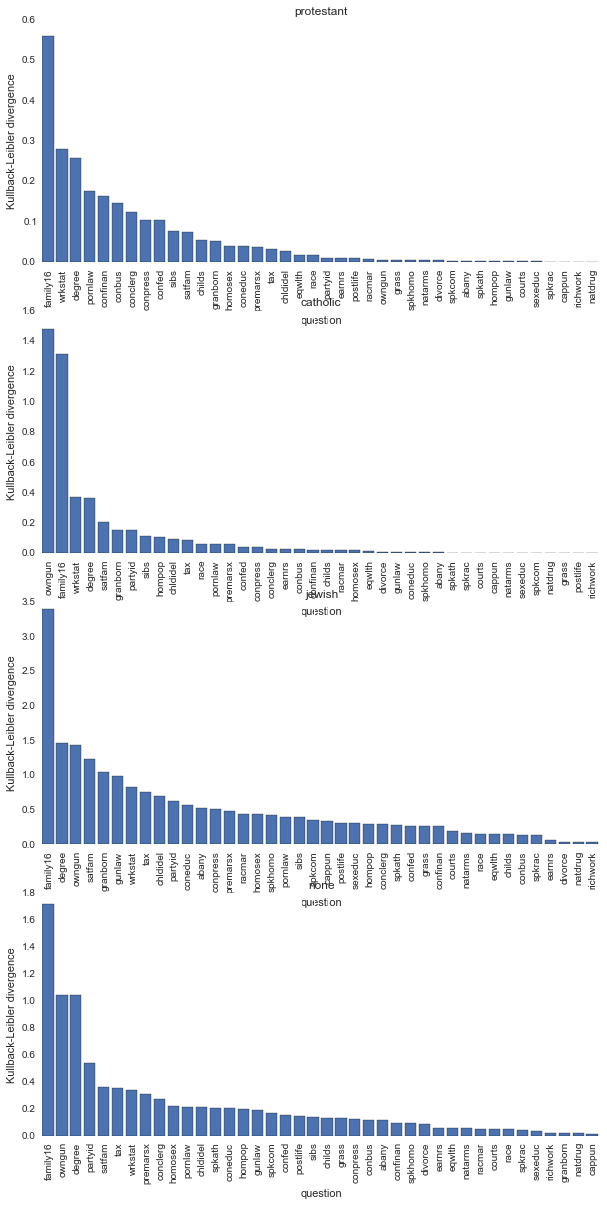

In [160]:
# plot the Kullback-Leibler divergence for a set of categories for the four largest religion groups
ListofCategories = ['wrkstat','divorce','sibs','childs','degree','hompop','partyid',
                    'natdrug','natarms','spkath','spkrac','spkcom','spkhomo','cappun','gunlaw','courts','grass',
                    'race','family16','granborn','earnrs','eqwlth','tax','postlife','racmar','satfam','confed',
                    'confinan','conclerg','conbus','coneduc','conpress','richwork','abany','chldidel','sexeduc',
                    'premarsx','homosex','pornlaw','owngun']
religions = ['protestant','catholic','jewish','none']
for i, religion in enumerate(religions):
    Divergencelist = ListofEntropies(ListofCategories, 'relig', religion)
    Divergences = []
    Categories = []
    numbers = np.arange(0, len(ListofCategories))
    for Divergence in Divergencelist:
        Divergences.append(Divergence[0])
        Categories.append(Divergence[1])
    plt.figure(1,(10,20))
    plt.subplot(len(religions), 1, i+1)
    plt.bar(numbers, Divergences)
    plt.xticks(np.arange(0.5, len(ListofCategories), 1), Categories, rotation = 90)
    plt.title(religion)
    plt.ylabel('Kullback-Leibler divergence')
    plt.xlabel('question')
    plt.tight_layout
    

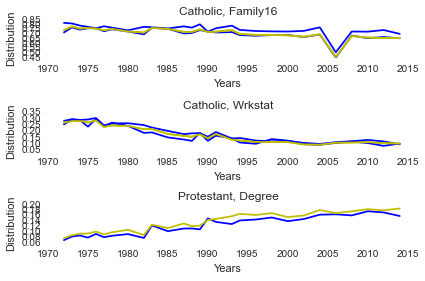

In [49]:

def ProtPlot():
    plt.subplot(311)
    dist1, years1 = distributionpartialpop(total_data, 'family16', 'mother & father', 'relig', 'protestant')
    dist2, years2 = distributiontotalpop(total_data, 'family16', 'mother & father')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="P")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Protestant, Family16')

    plt.subplot(312)
    dist1, years1 = distributionpartialpop(total_data, 'wrkstat', 'keeping house', 'relig', 'protestant')
    dist2, years2 = distributiontotalpop(total_data, 'wrkstat', 'keeping house')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="P")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Protestant, Wrkstat')
    
    plt.subplot(313)
    dist1, years1 = distributionpartialpop(total_data, 'degree', 'bachelor', 'relig', 'protestant')
    dist2, years2 = distributiontotalpop(total_data, 'degree', 'bachelor')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="P")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Protestant, Degree')
    
    plt.tight_layout()
    
    return

def CathPlot():
#     plt.subplot(313)
#     dist1, years1 = distributionpartialpop(total_data, 'owngun', 'yes', 'relig', 'catholic')
#     dist2, years2 = distributiontotalpop(total_data, 'owngun', 'yes')
#     plt.figure(1)
#     plt.plot(years1,dist1, c = 'b', label="C")
#     plt.plot(years1,dist2, c = 'y', label="T")
#     plt.xlabel('Years')
#     plt.ylabel('Distribution')
#     plt.title('Catholic, Owngun')

    plt.subplot(311)
    dist1, years1 = distributionpartialpop(total_data, 'family16', 'mother & father', 'relig', 'catholic')
    dist2, years2 = distributiontotalpop(total_data, 'family16', 'mother & father')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="C")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Catholic, Family16')


    plt.subplot(312)
    dist1, years1 = distributionpartialpop(total_data, 'wrkstat', 'keeping house', 'relig', 'catholic')
    dist2, years2 = distributiontotalpop(total_data, 'wrkstat', 'keeping house')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="C")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Catholic, Wrkstat')
    
    plt.tight_layout()
    
    return


def JewPlot():
    plt.subplot(311)
    dist1, years1 = distributionpartialpop(total_data, 'family16', 'mother & father', 'relig', 'jewish')
    dist2, years2 = distributiontotalpop(total_data, 'family16', 'mother & father')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="J")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Jewish, Family16')

    plt.subplot(312)
    dist1, years1 = distributionpartialpop(total_data, 'degree', 'bachelor', 'relig', 'jewish')
    dist2, years2 = distributiontotalpop(total_data, 'degree', 'bachelor')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="J")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('Jewish, Degree')
    
#     plt.subplot(313)
#     dist1, years1 = distributionpartialpop(total_data, 'owngun', 'no', 'relig', 'jewish')
#     dist2, years2 = distributiontotalpop(total_data, 'owngun', 'no')
#     plt.figure(1)
#     plt.plot(years1,dist1, c = 'b', label="J")
#     plt.plot(years1,dist2, c = 'y', label="T")
#     plt.xlabel('Years')
#     plt.ylabel('Distribution')
#     plt.title('Jewish, Owngun')
    
    plt.tight_layout()
    
    return

# Bluew = Jew?

def NonePlot():
    plt.subplot(311)
    dist1, years1 = distributionpartialpop(total_data, 'family16', 'mother & father', 'relig', 'none')
    dist2, years2 = distributiontotalpop(total_data, 'family16', 'mother & father')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="N")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('None, Family16')

#     plt.subplot(313)
#     dist1, years1 = distributionpartialpop(total_data, 'owngun', 'yes', 'relig', 'catholic')
#     dist2, years2 = distributiontotalpop(total_data, 'owngun', 'yes')
#     plt.figure(1)
#     plt.plot(years1,dist1, c = 'b', label="C")
#     plt.plot(years1,dist2, c = 'y', label="T")
#     plt.xlabel('Years')
#     plt.ylabel('Distribution')
#     plt.title('Catholic, Owngun')
    
    plt.subplot(312)
    dist1, years1 = distributionpartialpop(total_data, 'degree', 'bachelor', 'relig', 'none')
    dist2, years2 = distributiontotalpop(total_data, 'degree', 'bachelor')
    plt.figure(1)
    plt.plot(years1,dist1, c = 'b', label="N")
    plt.plot(years1,dist2, c = 'y', label="T")
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.title('None, Degree')
    
    plt.tight_layout()
    
    return


ProtPlot()

CathPlot()

